# Lab 5 - Server farms and load balancing - Célestin Piccin


Python code for the different cases of the lab

Simulating arrival rate = 5
Simulating arrival rate = 10
Simulating arrival rate = 15
Simulating arrival rate = 20
Simulating arrival rate = 25
Simulating arrival rate = 30
Simulating arrival rate = 35
Simulating arrival rate = 40
Simulating arrival rate = 45
Simulating arrival rate = 50
Simulating arrival rate = 55
Simulating arrival rate = 60
Simulating arrival rate = 65
Simulating arrival rate = 70
Simulating arrival rate = 75
Simulating arrival rate = 80
Simulating arrival rate = 85
Simulating arrival rate = 90
Simulating arrival rate = 95
Simulating arrival rate = 99

Results:
Arrival rate | Mean response time | 99th percentile |
------------:|-------------------:|----------------:|
           5 |              0.017 |           0.141 |
          10 |              0.017 |           0.141 |
          15 |              0.018 |           0.140 |
          20 |              0.018 |           0.143 |
          25 |              0.019 |           0.145 |
          30 |              0.020

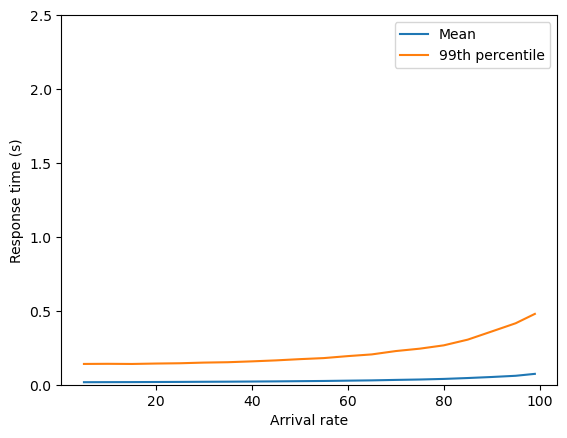

In [9]:
import random
from matplotlib import pyplot as plt
import simpy
import numpy as np


# ---------------------------------------------------------------------------
# Request generator
# ---------------------------------------------------------------------------
class Client:
    """A client generates requests and sends them to the load balancer."""
    def generate_requests(self, env, num_requests, arrival_rate, loadbalancer):
        """Generate new requests and send them to the load balancer."""

        for _ in range(num_requests):
            yield env.timeout(random.expovariate(arrival_rate))
            loadbalancer.handle_request()

# ---------------------------------------------------------------------------
# Load balancer
# ---------------------------------------------------------------------------
class LoadBalancer:
    """The loadbalancer manages n servers. It receives requests and forwards them to the servers.

       The load balancer may implement different task assignment policies,
       e.g., round-robin, random, etc.
    """

    def __init__(self, env, servers, policy):
        self.env = env
        self.servers = servers
        self.next_server = 0
        self.scheduling_policy = policy
        # For central queue implementation
        self.queue = simpy.Resource(env, capacity=1)
        # For weighted RR
        fast_rate = servers[0].service_rate
        slow_rate = servers[1].service_rate
        self.ratio = int(fast_rate / slow_rate)
        self.fast_count = 0

    def handle_request(self):
        """Choose a server and send the request to it."""
        arrival_time = self.env.now
        if self.scheduling_policy == "rr":
            server = self.round_robin()
            self.env.process(server.handle_request(arrival_time))
        elif self.scheduling_policy == "sqf":
            server = self.shortest_queue_first()
            self.env.process(server.handle_request(arrival_time))
        elif self.scheduling_policy == "cq":
            self.env.process(self.central_queue_handle(arrival_time))
        elif self.scheduling_policy == "wrr":
            server = self.weighted_round_robin()
            self.env.process(server.handle_request(arrival_time))

    # Load balancing policies ----------------------------------------------
    def round_robin(self):
        """Round-robin load balancing policy."""
        server = self.servers[self.next_server]
        self.next_server = (self.next_server + 1) % len(self.servers)
        return server
    
    def shortest_queue_first(self):
        """Shortest-queue-first scheduling policy"""
        return min(self.servers, key=lambda s: len(s.resource.queue))
    
    def weighted_round_robin(self):
        """Weighted round-robin that respects server service rates"""
        if self.fast_count < self.ratio:
            self.fast_count += 1
            return self.servers[0]  # Return fast server
        else:
            self.fast_count = 0
            return self.servers[1]  # Return slow server
    
    # Central queue request distribution -----------------------------------
    def central_queue_handle(self, arrival_time):
        """Central queue implementation"""
        with self.queue.request() as req: # Wait your turn in the central queue
            yield req
            # Find first available server
            while True:
                for server in self.servers:
                    if not server.resource.users:
                        self.env.process(server.handle_request(arrival_time))
                        return
                yield self.env.timeout(0.001)  # Small delay before checking again


# ---------------------------------------------------------------------------
# Server node
# ---------------------------------------------------------------------------
class Server:
    """A server that processes requests."""

    def __init__(self, env, service_rate, results):
        self.env = env
        self.service_rate = service_rate
        self.resource = simpy.Resource(env, capacity=1)
        self.results = results

    def handle_request(self, arrival_time):
        """Server process: handle the request and write the response time to the results"""

        job = self.resource.request()
        # Wait for the server to become available (wait in the queue)
        yield job
        # Process the request
        yield self.env.timeout(random.expovariate(self.service_rate))
        departure_time = self.env.now
        self.results.append(departure_time - arrival_time)
        self.resource.release(job)



# ===========================================================================
# Main functions to run the simulation with different configurations
# ===========================================================================
def main():
    """Run a number of simulations with different configurations. Generate the result plots.

       In the current implementation, this function runs the simulations of a
       load-balancing server farm.
       The arrival rate is varied for each run to evaluate the performance at different loads
    """

    # Simulation coniguration
    plot_file = "./visualizations/5_mixed.png"
    num_requests = 500_000
    
    # Service rate of two servers with different speeds
    fast_server_rate = 100
    slow_server_rate = 20
    
    # service_rates = [100] # Case 1 : M/M/1
    # service_rates = [20, 20, 20, 20, 20] # Case 2 and Case 4 : 5 servers
    # service_rates = [20, 20, 20, 20, 20, 20, 20] # Case 3 : RR with 7 servers
    
    service_rates = [fast_server_rate, slow_server_rate]  # Case 5 : 2 servers with different rates
    
    arrival_rates = list(range(5, 100, 5)) + [99] # List of arrival rates to simulate

    # Lists to store the results of the different simulation runs
    response_times_mean = []
    response_times_99 = []

    for arrival_rate in arrival_rates:
        print(f"Simulating arrival rate = {arrival_rate}")
        response_times = simulate(num_requests, arrival_rate, service_rates)

        response_times_mean.append(np.mean(response_times))
        response_times_99.append(np.percentile(response_times, 99))

    print_results_table(arrival_rates, response_times_mean, response_times_99)
    plot_results(plot_file, arrival_rates, response_times_mean, response_times_99)


# ---------------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------------
def simulate(num_requests, arrival_rate, service_rates):
    """Run a single simulation with the given parameters."""
    response_times = [] # Used for the simulation results

    # Configure the nodes
    env = simpy.Environment()
    client = Client()
    servers = [Server(env, service_rate, response_times) for service_rate in service_rates]
    
    # Create the load balancer, you need to specify the policy here, the possible options are:
    # wrr = weighted round robin
    # rr = round robin
    # sqf = shortest queue first
    # cq = central queue
    load_balancer = LoadBalancer(env, servers, policy="wrr")

    # Run the simulation
    env.process(client.generate_requests(env, num_requests, arrival_rate, load_balancer))
    env.run()
    return response_times


def print_results_table(arrival_rates, response_times_mean, response_times_99):
    """Print the results in a table format."""
    print()
    print("Results:")
    print("Arrival rate | Mean response time | 99th percentile |")
    print("------------:|-------------------:|----------------:|")
    for i, arrival_rate in enumerate(arrival_rates):
        print(f"{arrival_rate:>12.0f} | {response_times_mean[i]:>18.3f} | {response_times_99[i]:>15.3f} |")

def plot_results(filename, arrival_rates, response_times_mean, response_times_99):
    """Plot the results in a graph."""
    plt.plot(arrival_rates , response_times_mean, label="Mean")
    plt.plot(arrival_rates, response_times_99, label="99th percentile")
    plt.ylim(0, 2.5)
    plt.xlabel("Arrival rate")
    plt.ylabel("Response time (s)")
    plt.legend()
    plt.savefig(filename)
    print()
    print(f"Plot saved to {filename}")


# ---------------------------------------------------------------------------
# Run one of the simulation types

main()
